In [ ]:
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tank_env

env = gym.make('CartPole-v1')

Tank Env initialized


/root/miniconda3/envs/torch_env/lib/python3.11/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment gymnasium_env/TankEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


tensor([[ 2.9834, -4.3944, 24.1203,  7.3517]], device='cuda:0', grad_fn=<AddmmBackward0>) torch.Size([1, 4])

백본 형상 구현

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import TensorDataset, DataLoader
from torch import distributions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BackboneNetwork(nn.Module):
    def __init__(self, in_features, hidden_dimensions, out_features, dropout):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden_dimensions)
        self.layer2 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.layer3 = nn.Linear(hidden_dimensions, out_features)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.layer1(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x

액터 크리틱 구현 : 액터는 클립을 적용한 행동 정책, 크리틱은 상태의 가치 측정. 백본 네트워크의 형상을 공유하여 생성될 것임

In [21]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic
    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        return action_pred, value_pred

액터와 크리틱을 포함하는 에이전트 구현

In [22]:
def create_agent(hidden_dimensions, dropout):
    INPUT_FEATURES = env.observation_space.shape[0]
    HIDDEN_DIMENSIONS = hidden_dimensions
    ACTOR_OUTPUT_FEATURES = env.action_space.n
    CRITIC_OUTPUT_FEATURES = 1
    DROPOUT = dropout
    actor = BackboneNetwork(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, ACTOR_OUTPUT_FEATURES, DROPOUT).to(device)
    critic = BackboneNetwork(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, CRITIC_OUTPUT_FEATURES, DROPOUT).to(device)
    agent = ActorCritic(actor, critic)
    return agent

누적 보상 계산 함수 : 맨 뒤의 보상부터 더해가면서 할인율을 누적 곱셈하여 할인을 구현

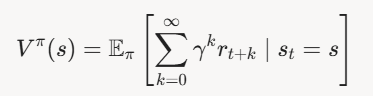

In [23]:
def calculate_returns(rewards, discount_factor):
    returns = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + cumulative_reward * discount_factor
        returns.insert(0, cumulative_reward)
    returns = torch.tensor(returns).to(device)
    # normalize the return
    returns = (returns - returns.mean()) / returns.std()
    return returns

어드밴티지 함수 구현 : 크리틱이 예측한 가치와 액터가 정책에 따라 선택한 행동의 예상 리턴 간 차이

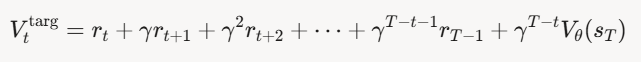

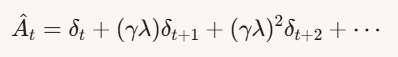

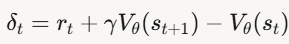

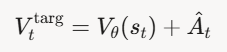

In [24]:
def calculate_advantages(returns, values):
    advantages = returns - values
    # Normalize the advantage
    advantages = (advantages - advantages.mean()) / advantages.std()
    return advantages

대리 보상 손실 구현: 정책 네트워크와 가치 네트워크를 조화롭게 학습하기 위한 손실 로직

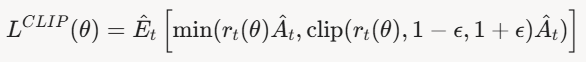 이때, 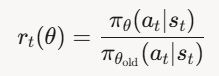

In [25]:
def calculate_surrogate_loss(
        actions_log_probability_old,
        actions_log_probability_new,
        epsilon,
        advantages):
    advantages = advantages.detach()
    policy_ratio = (
            actions_log_probability_new - actions_log_probability_old
            ).exp()
    surrogate_loss_1 = policy_ratio * advantages
    surrogate_loss_2 = torch.clamp(
            policy_ratio, min=1.0-epsilon, max=1.0+epsilon
            ) * advantages
    surrogate_loss = torch.min(surrogate_loss_1, surrogate_loss_2)
    return surrogate_loss

손실을 계산하는 함수. 대리 목적 손실과 가치 손실 및 엔트로피를 적용하여 최종 손실을 구함

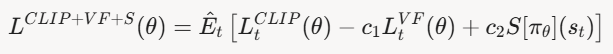 이때, 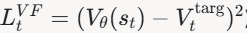

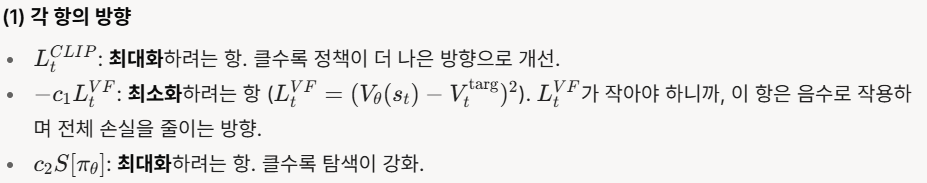

In [26]:
# surrogate_loss: 이전에 계산된 서로게이트 손실 텐서 (예: calculate_surrogate_loss 함수의 출력).
# entropy: 정책의 엔트로피 값 (탐험을 장려하기 위한 항).
# entropy_coefficient: 엔트로피 보너스의 가중치 (하이퍼파라미터, 보통 0.01~0.1).
# returns: 실제 누적 보상(할인된 리턴, Discounted Returns).
# value_pred: 크리틱 네트워크가 예측한 상태 가치(Value).

def calculate_losses(surrogate_loss, entropy, entropy_coefficient, returns, value_pred):
    entropy_bonus = entropy_coefficient * entropy
    policy_loss = -(surrogate_loss + entropy_bonus).sum() # 딥러닝 모델은 손실을 '최소화'하려 하므로 '최대화'되어야 할 값에 음수를 취함 
    value_loss = f.smooth_l1_loss(returns, value_pred).sum() # smooth_l1_loss는 이상치에 덜 민감함 
    return policy_loss, value_loss

1. 보상을 구해 현재 상태의 가치를 뺄셈하여 어드밴티지를 산출
2. 어드밴티지를 사용해 대리 손실 함수 값을 산출
3. 각 값을 사용해서 Loss를 산출

에피소드 하나의 정보를 저장하고 update_policy 함수의 인자로 넘겨주기 위한 공간을 선언

In [27]:
def init_training():
    states = []
    actions = []
    actions_log_probability = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    return states, actions, actions_log_probability, values, rewards, done, episode_reward

에피소드의 스텝을 진행하면서 agent를 통해 행동의 확률값, 가치 예측치를 계산하면서 종합된 상태와 행동과 보상의 리스트를 반환

In [28]:
def forward_pass(env, agent, optimizer, discount_factor):
    states, actions, actions_log_probability, values, rewards, done, episode_reward = init_training()
    state, _ = env.reset() # 환경 초기화로 상태를 받아옴
    agent.train() # nn.Module 클래스의 함수 
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device) # 상태를 텐서로
        states.append(state) # states 버퍼에 상태를 추가
        action_pred, value_pred = agent(state) # forward()가 수행된다고 봐야  
        action_prob = f.softmax(action_pred, dim=-1) # action_pred는 로짓(logit)이기 때문에 소프트맥스 함수로 확률로 변환 
        dist = distributions.Categorical(action_prob) # 확률 분포로 바꾸는데 카테고리컬하게
        action = dist.sample() # 확률 분포에 따라 행동 샘플링 
        log_prob_action = dist.log_prob(action) # 선택된 행동의 로그 확률을 계산하여 추후 대리 목적 함수 계산에 사용 
        state, reward, terminated, truncated, _ = env.step(action.item()) # 행동 텐서를 스칼라로 변환하여 환경 1스텝 진행 및 다음 값 받음
        done = terminated or truncated
        actions.append(action) # actions 버퍼에 행동을 추가
        actions_log_probability.append(log_prob_action) # 마찬가지로 버퍼에 추가
        values.append(value_pred)
        rewards.append(reward)
        episode_reward += reward
    states = torch.cat(states).to(device) # 리스트에 저장된 상태 텐서들을 연결하여 단일 텐서로 만듬
    actions = torch.cat(actions).to(device)
    actions_log_probability = torch.cat(actions_log_probability).to(device)
    values = torch.cat(values).squeeze(-1).to(device) # 가치 예측 텐서들을 연결하고 마지막 차원을 제거
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    return episode_reward, states, actions, actions_log_probability, advantages, returns

완료된 에피소드에서 수집된 값으로 모델을 학습하는 코드

In [29]:
def update_policy(
        agent,
        states,
        actions,
        actions_log_probability_old,
        advantages,
        returns,
        optimizer,
        ppo_steps,
        epsilon,
        entropy_coefficient):
    BATCH_SIZE = 128
    total_policy_loss = 0
    total_value_loss = 0
    actions = actions.detach() # 과거의 행동을 고정해야 같은 행동에 대한 새로운 예측치를 산출할 수 있음 
    actions_log_probability_old = actions_log_probability_old.detach() # 대리 손실 함수 계산을 위해 과거 확률 고정
    training_results_dataset = TensorDataset(
            states,
            actions,
            actions_log_probability_old,
            advantages,
            returns)
    batch_dataset = DataLoader(
            training_results_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False)
    for _ in range(ppo_steps):
        for batch_idx, (states, actions, actions_log_probability_old, advantages, returns) in enumerate(batch_dataset):
            # 입력된 모든 상태 정보에 대한 새로운 행동, 가치 예측치를 산출 
            action_pred, value_pred = agent(states)
            value_pred = value_pred.squeeze(-1).to(device)
            action_prob = f.softmax(action_pred, dim=-1)
            probability_distribution_new = distributions.Categorical(
                    action_prob)
            entropy = probability_distribution_new.entropy()
            # 과거 행동 확률과 새로운 행동 확률을 calculate_surrogate_loss 함수에 전달  
            actions_log_probability_new = probability_distribution_new.log_prob(actions)
            surrogate_loss = calculate_surrogate_loss(
                    actions_log_probability_old,
                    actions_log_probability_new,
                    epsilon,
                    advantages)
            # 산출된 대리 목적 손실, 엔트로피, 누적 보상과 예측치를 사용하여 정책 손실과 가치 손실을 산출 
            policy_loss, value_loss = calculate_losses(
                    surrogate_loss,
                    entropy,
                    entropy_coefficient,
                    returns,
                    value_pred)
            # 최적화 함수 기울기 초기화
            optimizer.zero_grad()
            # 정책 손실 기울기 역전파
            policy_loss.backward()
            # 가치 손실 기울기 역전파
            value_loss.backward()
            # 기울기 합산하여 적용 후 다음 단계로 진행 
            optimizer.step()
            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()
    # 평균 정책 손실과 평균 가치 손실을 반환 
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

학습된 모델의 성능을 평가하는 함수

In [30]:
def evaluate(env, agent):
    agent.eval() # nn.Module에 포함된 함수 
    rewards = [] 
    done = False
    episode_reward = 0
    state, _ = env.reset()
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action_pred, _ = agent(state)
            action_prob = f.softmax(action_pred, dim=-1)
        action = torch.argmax(action_prob, dim=-1).to(device)
        state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        episode_reward += reward
    return episode_reward

In [31]:
import matplotlib.pyplot as plt

def plot_train_rewards(train_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(train_rewards, label='Training Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Training Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(train_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [32]:
def plot_test_rewards(test_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(test_rewards, label='Testing Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Testing Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(test_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [33]:
def plot_losses(policy_losses, value_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(value_losses, label='Value Losses')
    plt.plot(policy_losses, label='Policy Losses')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [34]:
episode_durations = []

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

CartPole 환경에서 PPO를 테스트하는 함수

In [35]:
def run_ppo():
    MAX_EPISODES = 1000              
    DISCOUNT_FACTOR = 0.99
    REWARD_THRESHOLD = 20
    PRINT_INTERVAL = 10
    PPO_STEPS = 10
    N_TRIALS = 128
    EPSILON = 0.25
    ENTROPY_COEFFICIENT = 0.02
    HIDDEN_DIMENSIONS = 64
    DROPOUT = 0.2
    LEARNING_RATE = 0.001
    train_rewards = []
    test_rewards = []
    policy_losses = []
    value_losses = []
    agent = create_agent(HIDDEN_DIMENSIONS, DROPOUT)
    print('Agent Initialized')
    optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE)
    print('Optimizer Initialized')
    for episode in range(1, MAX_EPISODES+1):
        train_reward, states, actions, actions_log_probability, advantages, returns = forward_pass(
                env,
                agent,
                optimizer,
                DISCOUNT_FACTOR)
        print(f'Episode {episode}')
        episode_durations.append(len(actions) + 1)
        plot_durations()
        policy_loss, value_loss = update_policy(
                agent,
                states,
                actions,
                actions_log_probability,
                advantages,
                returns,
                optimizer,
                PPO_STEPS,
                EPSILON,
                ENTROPY_COEFFICIENT)
        # test_reward = evaluate(env_test, agent)
        # policy_losses.append(policy_loss)
        # value_losses.append(value_loss)
        # train_rewards.append(train_reward)
        # test_rewards.append(test_reward)
        # mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
        mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
        # mean_abs_policy_loss = np.mean(np.abs(policy_losses[-N_TRIALS:]))
        # mean_abs_value_loss = np.mean(np.abs(value_losses[-N_TRIALS:]))
        
        # if episode % PRINT_INTERVAL == 0:
        #     print(f'Episode: {episode:3} | \
        #           Mean Train Rewards: {mean_train_rewards:3.1f} \
        #           | Mean Test Rewards: {mean_test_rewards:3.1f} \
        #           | Mean Abs Policy Loss: {mean_abs_policy_loss:2.2f} \
        #           | Mean Abs Value Loss: {mean_abs_value_loss:2.2f}')
        if mean_test_rewards >= REWARD_THRESHOLD:
            print(f'Reached reward threshold in {episode} episodes')
            break
#     plot_train_rewards(train_rewards, REWARD_THRESHOLD)
#     plot_test_rewards(test_rewards, REWARD_THRESHOLD)
#     plot_losses(policy_losses, value_losses)

In [36]:
run_ppo()

Agent Initialized
Optimizer Initialized


TypeError: 'NoneType' object is not iterable